In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas_bokeh
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.plotting import figure
output_notebook(INLINE)
# pandas_bokeh.output_notebook()

import gc, os, pickle, random, time, cmath, re
import geopy
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

from contextlib import contextmanager
import multiprocessing
import shap

# import librosa
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from lightgbm import LGBMClassifier, LGBMRegressor
from category_encoders import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

/home/kevinco27/.local/lib/python3.5/site-packages/pandas_bokeh/__init__.py:24: Warning: Could not define plot method for Pandas DataFrame and Series. Please make sure that Pandas is installed if you wish to use Bokeh as plotting backend for Pandas. 

Exceptions: cannot import name 'CachedAccessor' 
  Warning,


Loading BokehJS ...

In [2]:
def load_df(dataset):
    if 'train' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    elif 'test' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    return df

print('Download Train and Test Data.\n')
with multiprocessing.Pool() as pool: 
    train, test = pool.map(load_df, ["train", "test"])

def attr_map(train, test):

    train['city'] = train['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    test['city'] = test['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    return train, test

train, test = attr_map(train, test)

combine = pd.concat([train, test])
target = train['total_price']


Download Train and Test Data.



In [3]:
@contextmanager
def timer(name):
    """
    utility timer function to check how long a piece of code might take to run.
    :param name: name of the code fragment to be timed
    :yield: time taken for the code to run
    """
    t0 = time.time()
    print('[%s] in progress' % name)
    yield
    print('[%s] done in %.0f s' %(name, time.time() - t0))

## city map 中文

In [6]:
fig, ax = plt.subplots(figsize = (10,10))
for label in combine.city.unique():
    
    ax.plot(combine.lon[combine.city == label],combine.lat[combine.city == label],'.', 
            alpha = 0.4, markersize = 0.1)
    
    ax.plot(np.mean(combine.lon[combine.city == label]), np.mean(combine.lat[combine.city == label]),'o',
            color = 'r')

    ax.annotate(label, 
                (np.mean(combine.lon[combine.city == label]), 
                np.mean(combine.lat[combine.city == label])), 
                color = 'g', fontsize = 15)
    
ax.set_title('Cluster Centers')
plt.show()


![](../fig/image.png)

In [16]:

X1 = np.matrix([(117.2,-40.01), (119.66,-37.75), (118.02,-37.93)])
X2 = np.matrix([(120.713287,21.987057), (121.775596, 25.142056), (120.499489, 24.214840)])
T = inv(X1.T * X1) * X1.T * X2
coor_trans = np.matrix(combine[['lon', 'lat']])*T
train2 = combine.assign(lon_trans=coor_trans[:,0].reshape(1,-1).tolist()[0],
                      lat_trans=coor_trans[:,1].reshape(1,-1).tolist()[0])


train2.plot_bokeh.map(
    x='lon_trans',
    y='lat_trans',
    size=1,
    figsize=(800,800)
)

- 3:基隆, 13:台北, 7:新北, 10:桃園, 9:新竹, 17:苗栗,
- 12:台中, 6:彰化, 14:台南, 21:高雄, 5:屏東


In [33]:
# 新竹
train[train['city']==9]['total_price'].describe()

count    1.125000e+03
mean     1.105863e+07
std      3.325617e+07
min      3.964520e+05
25%      2.432527e+06
50%      4.892756e+06
75%      1.019580e+07
max      6.307002e+08
Name: total_price, dtype: float64

In [40]:
train[train['city']==13]['total_price'].describe()

count    1.075600e+04
mean     3.282438e+07
std      1.063612e+08
min      5.638755e+05
25%      8.510296e+06
50%      1.546996e+07
75%      3.062613e+07
max      5.088279e+09
Name: total_price, dtype: float64

## 分別 city 的 房價分析 ～

In [27]:
df = pd.DataFrame()
df['city'] = train.city.unique()
df.set_index('city')

df[df.index==0]

city
0  Kaohsiung

In [36]:
df = pd.DataFrame()
df['city'] = train.city.unique()
mean = []; median =[]; var=[]; std=[]; MAX=[]; MIN = [];
for i in train.city.unique():
    
    mean.append(np.mean(train[train['city'] == i]['total_price']))
    median.append(np.median(train[train['city'] == i]['total_price']))
    var.append(np.var(train[train['city'] == i]['total_price']))
    std.append(np.std(train[train['city'] == i]['total_price']))
    MAX.append(np.max(train[train['city'] == i]['total_price']))
    MIN.append(np.round(np.min(train[train['city'] == i]['total_price']),0))
    
df['mean'] = mean;df['median'] = median; df['var'] = var; df['std'] =std; df['MAX']=MAX; df['MIN']=MIN
df.set_index('city')


mean        median           var           std  \
city                                                                
Kaohsiung  6.140482e+06  2.432520e+06  1.309700e+15  3.618978e+07   
NewTaipei  1.141214e+07  6.521007e+06  1.833172e+15  4.281556e+07   
Taichung   8.723268e+06  4.120926e+06  6.684838e+14  2.585505e+07   
Miaoli     4.986385e+06  2.432564e+06  2.602811e+14  1.613323e+07   
TaoYuan    6.428259e+06  3.321452e+06  1.898677e+14  1.377925e+07   
Taipei     3.282438e+07  1.546996e+07  1.131164e+16  1.063562e+08   
Tainan     5.913154e+06  2.727088e+06  3.702702e+14  1.924241e+07   
Keelung    3.055048e+06  1.648821e+06  1.972529e+13  4.441316e+06   
Changhua   5.685890e+06  2.585255e+06  1.661257e+14  1.288897e+07   
Pingtung   3.348418e+06  1.235981e+06  1.391028e+14  1.179419e+07   
Hsinchu    1.105863e+07  4.892756e+06  1.104990e+15  3.324139e+07   

                    MAX       MIN  
city                               
Kaohsiung  2.038068e+09  229975.0  
NewTaipei  2.169519e+09  353184.0  
Taichung   1.423615e+09  226150.0  
Miaoli     4.524503e+08  249023.0  
TaoYuan    3.676199e+08  262964.0  
Taipei     5.088279e+09  563875.0  
Tainan     6.313162e+08  237865.0  
Keelung    4.429957e+07  301261.0  
Changhua   2.468440e+08  339560.0  
Pingtung   2.246702e+08  237865.0  
Hsinchu    6.307002e+08  396452.0

- Taipei 房價太高，是否合適一起訓練？

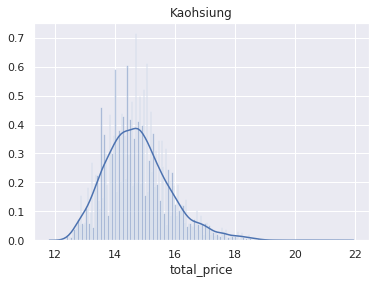

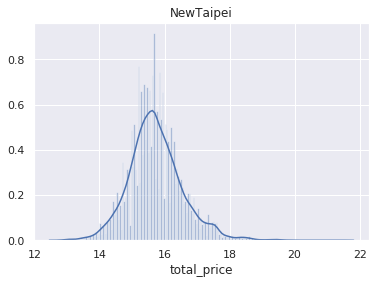

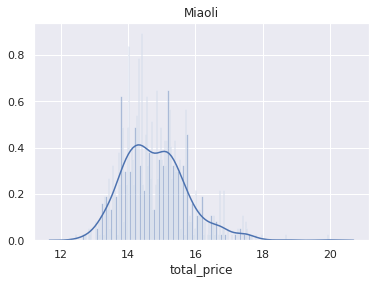

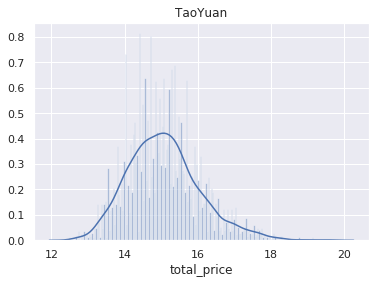

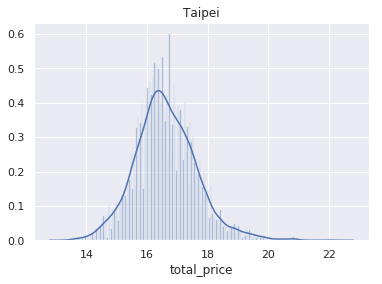

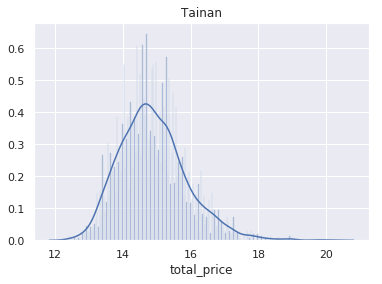

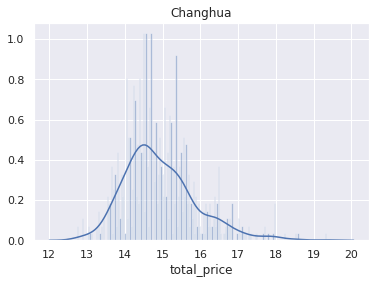

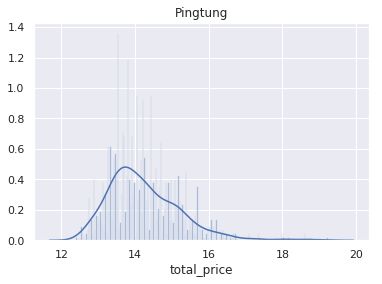

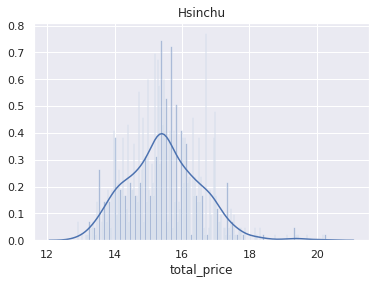

In [40]:
# np.square(trn[target])
for i in train.city.unique():
    sns.distplot(np.log1p(train[train['city'] == i]['total_price']), bins = 200)
    plt.title(i)
    plt.show()
    
# 苗栗有兩個高斯，新竹有pike，屏東右偏很多

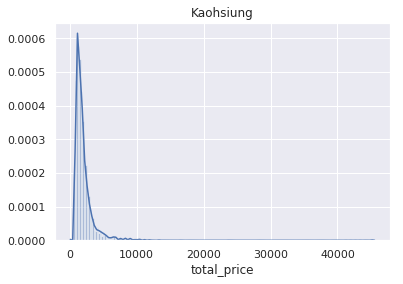

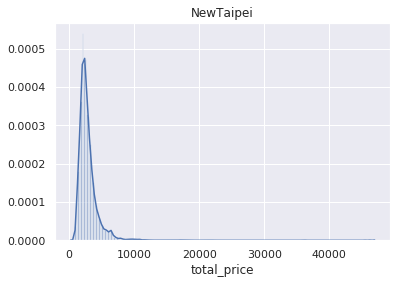

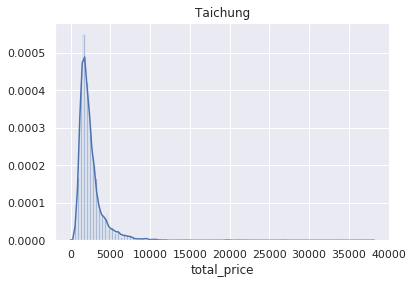

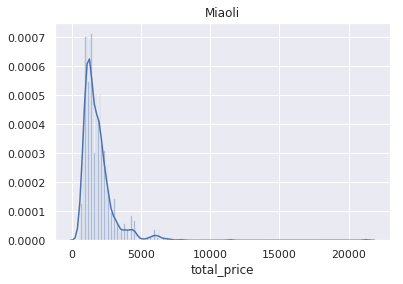

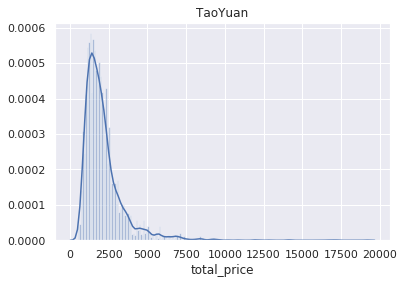

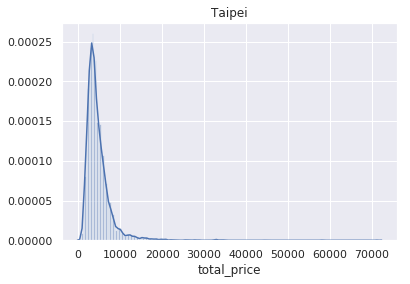

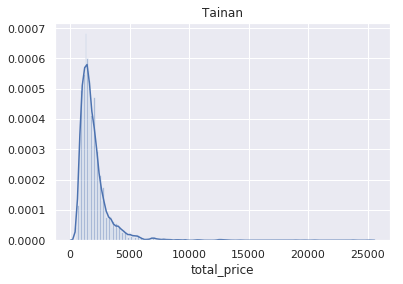

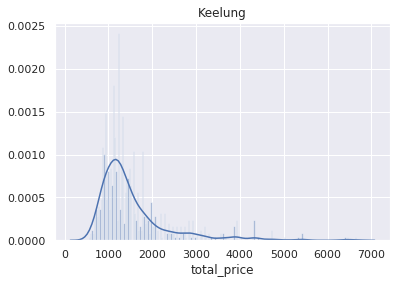

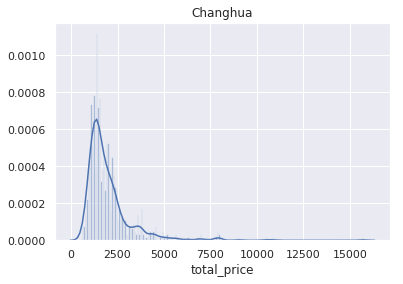

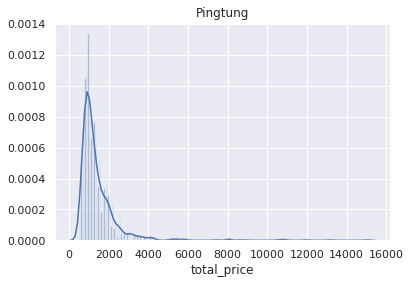

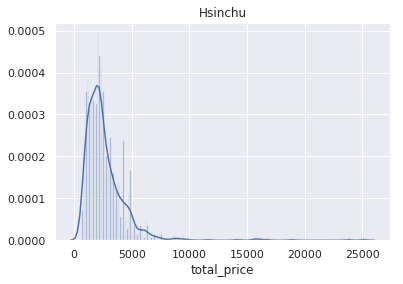

In [4]:
# np.square(trn[target])
for i in train.city.unique():
    sns.distplot(np.sqrt(train[train['city'] == i]['total_price']), bins = 200)
    plt.title(i)
    plt.show()
    
# 苗栗有兩個高斯，新竹有pike，屏東右偏很多

# 建築物 category
- village 村里
- building_material 建材
- building_type 建物型態
- building_use 建物用途 (4,5 高價位多一個order)
- parking_way 車位停放方式

In [61]:
train[ 'parking_way'].value_counts()

2    46065
0    10923
1     3012
Name: parking_way, dtype: int64

In [56]:
# li = ['village', 'building_material', 'building_type', 'building_use', 'parking_way']
li = [ 'parking_way']

for i in train.city.unique():
    for j in li:
        print(i, j, train[train['city']==i][j].nunique())

Kaohsiung parking_way 3
NewTaipei parking_way 3
Taichung parking_way 3
Miaoli parking_way 3
TaoYuan parking_way 3
Taipei parking_way 3
Tainan parking_way 3
Keelung parking_way 3
Changhua parking_way 3
Pingtung parking_way 3
Hsinchu parking_way 3


In [48]:
train.groupby([ 'building_material'])['total_price'].median()

building_material
1     3.510815e+06
3     9.870214e+05
4     3.840336e+06
5     7.634121e+07
7     1.979801e+06
8     5.596452e+06
9     2.254567e+07
10    4.430267e+07
11    1.914742e+06
Name: total_price, dtype: float64

In [94]:
train[['village', 'building_material','building_type', 'building_use', 'parking_way']].head()


village  building_material  building_type  building_use  parking_way
0     3132                  8              3             2            2
1      921                  8              1             2            2
2     1544                  8              1             2            2
3     3350                  8              0             2            0
4       63                  1              4             2            2

- 用這些數字(11/213/219/482)去類聚 lon/lat ～ Kmeans K
- lon ~ 231
- lat ~ 190
- lonlat ~ 609

## Missing Values
- parking_area               56897
- parking_price              46065
- txn_floor                  15902
- village_income_median       1142

## Date EDA
### 找出時間序列的相關因素

- txn_floor 交易樓層
- txn_dt 交易日期
- building_complete_dt 建物完成日期

## Encoding

In [3]:
# use target encoding to encode two categorical features
train['lonlat'] = train['lon']+train['lat']
test['lonlat'] = test['lon']+test['lat']

target_cate = ['lonlat']
target_num = ['total_price']
for i in target_cate:
    for j in target_num:
        enc = TargetEncoder(cols=[i]).fit(train[i], train[j])

        training_numeric_dataset = enc.transform(train[i], train[j])#.rename(cols={'city':'city_targ'})
        testing_numeric_dataset = enc.transform(test[i])

        training_numeric_dataset.rename(columns={i:i +'_targ_'+j}, inplace=True)
        testing_numeric_dataset.rename(columns={i:i +'_targ_'+j}, inplace=True)

        train[i +'_targ_' + j] = training_numeric_dataset
        test[i +'_targ_' + j] = testing_numeric_dataset
        del training_numeric_dataset, testing_numeric_dataset;
        gc.collect()

## Statistic Features Engineer

In [3]:
##################    UtilityFunction    #################
# nunique, mean, std, median, max, min, sum, var, quantile

def do_count( df, group_cols, agg_type='uint16', show_max=False, show_agg=True ):
    agg_name='{}count'.format('_'.join(group_cols))  
    if show_agg:
        print( "\nAggregating by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_countuniq( df, group_cols, counted, agg_type='uint8', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_cumcount( df, group_cols, counted,agg_type='uint16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_cumcount'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCumulative count by ", group_cols , '... and saved in', agg_name  )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_mean'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating mean of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_median( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_median'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating median of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].median().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_max( df, group_cols, counted, agg_type='float16', show_agg=True ):
    agg_name= '{}_by_{}_max'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating Max of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].max().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_min( df, group_cols, counted, agg_type='float16', show_agg=True ):
    agg_name= '{}_by_{}_min'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating min of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].min().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_sum( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_sum'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCalculating sum of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_type='float16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_var'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCalculating variance of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )


In [95]:
# combine[['city','I_50','I_index_50']]
combine[['town_population','town_area','town_population_density']].head()

town_population  town_area  town_population_density
0          24219.0     1.4161                  17103.0
1         551480.0    23.1373                  23835.0
2         551480.0    23.1373                  23835.0
3         139259.0    14.7523                   9440.0
4         112397.0    71.0400                   1582.0

## Feature index Count interaction

In [139]:
ROME = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV']
indices = random.sample(range(len(ROME)), 5)
[ROME[i] for i in sorted(indices)]

['VI', 'VII', 'VIII', 'IX', 'XI']

In [125]:
def index_interaction(df, num):    
    ROME = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV']
    feats = [i for i in train.columns if not(i.endswith('10000')) and not(i.endswith('5000')) and ('index' in i)]
    feats = [i for i in feats if i.endswith(str(num)) ]
    

{'III_index_1000',
 'III_index_50',
 'III_index_500',
 'II_index_1000',
 'II_index_50',
 'II_index_500',
 'IV_index_1000',
 'IV_index_50',
 'IV_index_500',
 'IX_index_1000',
 'IX_index_50',
 'IX_index_500',
 'I_index_1000',
 'I_index_50',
 'I_index_500',
 'VIII_index_1000',
 'VIII_index_50',
 'VIII_index_500',
 'VII_index_1000',
 'VII_index_50',
 'VII_index_500',
 'VI_index_1000',
 'VI_index_50',
 'VI_index_500',
 'V_index_1000',
 'V_index_50',
 'V_index_500',
 'XIII_index_1000',
 'XIII_index_50',
 'XIII_index_500',
 'XII_index_1000',
 'XII_index_50',
 'XII_index_500',
 'XIV_index_1000',
 'XIV_index_50',
 'XIV_index_500',
 'XI_index_1000',
 'XI_index_50',
 'XI_index_500',
 'X_index_1000',
 'X_index_50',
 'X_index_500'}

In [4]:
combine = pd.concat([train, test])

combine = do_sum( combine, ['village'], 'I_index_50'); gc.collect()
combine = do_sum( combine, ['village'], 'I_index_500'); gc.collect()
combine = do_sum( combine, ['village'], 'I_index_1000'); gc.collect()


combine = do_sum( combine, ['town'], 'I_index_50'); gc.collect()
combine = do_sum( combine, ['town'], 'I_index_500'); gc.collect()
combine = do_sum( combine, ['town'], 'I_index_1000'); gc.collect()

combine['town_I_index_50_sum_div_popu'] = combine['town_by_I_index_50_sum'] / combine['town_population']
combine['town_I_index_50_sum_div_area'] = combine['town_by_I_index_50_sum'] / combine['town_area']
combine['town_I_index_500_sum_div_popu'] = combine['town_by_I_index_500_sum'] / combine['town_population']
combine['town_I_index_500_sum_div_area'] = combine['town_by_I_index_500_sum'] / combine['town_area']

# 'town_population','town_area'


Calculating sum of  I_index_50  by  ['village'] ... and saved in village_by_I_index_50_sum

Calculating sum of  I_index_500  by  ['village'] ... and saved in village_by_I_index_500_sum

Calculating sum of  I_index_1000  by  ['village'] ... and saved in village_by_I_index_1000_sum

Calculating sum of  I_index_50  by  ['town'] ... and saved in town_by_I_index_50_sum

Calculating sum of  I_index_500  by  ['town'] ... and saved in town_by_I_index_500_sum

Calculating sum of  I_index_1000  by  ['town'] ... and saved in town_by_I_index_1000_sum


In [ ]:
# CATEGORY
# Geo: city, town, village
# Area: land_area, building_area

# NUMERICS
'''
village_income_median 所在里年收入中位數
town_population 所在鄉鎮市區人口數
town_area 所在鄉鎮市區面積
town_population_density 所在鄉鎮市區人口密度
'''


## Model Evaluation

In [5]:
train = combine[combine['total_price'].notnull()]
test = combine[combine['total_price'].isnull()]

In [ ]:
def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.tight_layout()
    plt.show()
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    
def hit_rate(y_true, y_pred):
    return np.mean(np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)]))

def Mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true)/y_true))

def score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return (np.round(hit_rate(y_true, y_pred), 4)*1e4 + 1 - Mape(y_true, y_pred))

def model(trn, sub, folds):
    
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat']]
#     combine = pd.concat([trn[feats], sub[feats]])
    X = trn[feats]
    y = np.log1p(target)
    
    
    sss = KFold(n_splits=5,shuffle=True, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(combine.shape[0])
    
    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = LGBMRegressor(n_estimators=100000,
                            learning_rate =  0.007,#0.003,
                            num_leaves=31,                
                            feature_fraction = 0.6,
                            bagging_fraction= 0.7,
                            n_josb=-1)
        
        clf.fit(X_train, y_train, eval_set=[ (X_test, y_test )], 
                eval_metric= 'mse', verbose= 3000, early_stopping_rounds= 500)
        
        y_pred = np.expm1(clf.predict(X_test, num_iteration=clf.best_iteration_))
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate plus MAPE: {}'.format(score(np.expm1(y_test), y_pred)))
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(X_test)[:,:sub[feats].shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    display_importances(feature_importance_df)
    display_shapley_values(feature_importance_df)

model(train, test, folds=5)

Training until validation scores don't improve for 500 rounds.
[3000]	valid_0's l2: 0.0519914	valid_0's l2: 0.0519914
[6000]	valid_0's l2: 0.0468739	valid_0's l2: 0.0468739
[9000]	valid_0's l2: 0.0445122	valid_0's l2: 0.0445122
[12000]	valid_0's l2: 0.0430011	valid_0's l2: 0.0430011
[15000]	valid_0's l2: 0.0420642	valid_0's l2: 0.0420642
[18000]	valid_0's l2: 0.0414503	valid_0's l2: 0.0414503
[21000]	valid_0's l2: 0.0409993	valid_0's l2: 0.0409993
[24000]	valid_0's l2: 0.0406383	valid_0's l2: 0.0406383
